# **Visión computacional para imágenes y video**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr. Gilberto Ochoa Ruiz**
### **Tecnológico de Monterrey**
## **7.2 Google Colab algoritmos de extracción de características**

---

### Equipo 37

- Jorge Luis Ancheyta Segovia - A01796354
- Omar Aguilar Macedo - A01797078

# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)
6. [Challenge](#challenge)
    1. [Discusión](#discusion)

## Importing Libraries <a class="anchor" name="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage import convolve

## 1. Color to Grayscale <a class="anchor" name="grayscale" ></a>

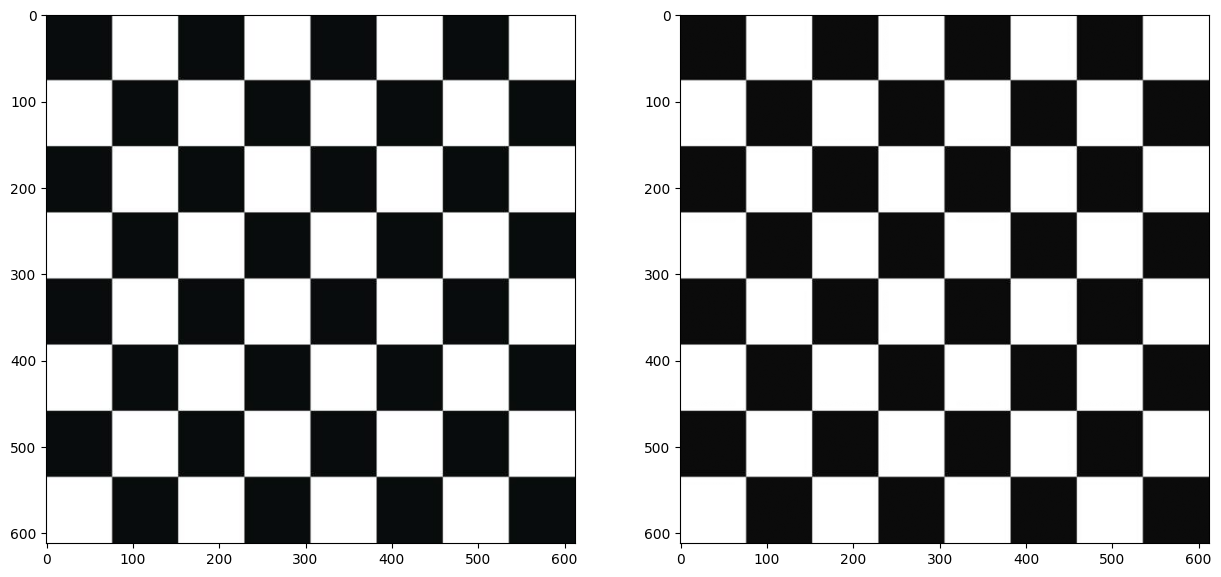

In [2]:
img = cv2.imread('data/chessboard.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 2. Spatial derivative calculation <a class="anchor" name="spatial" ></a>

In [3]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 3. Structure tensor setup <a class="anchor" name="tensor" ></a>

In [4]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 4. Harris response calculation <a class="anchor" name="response" ></a>

In [5]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy

harris_response = detA - k * traceA ** 2

In [6]:
img_gray.shape

(612, 612)

In [7]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [8]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 5. Find edges and corners using R <a class="anchor" name="find" ></a>

In [9]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

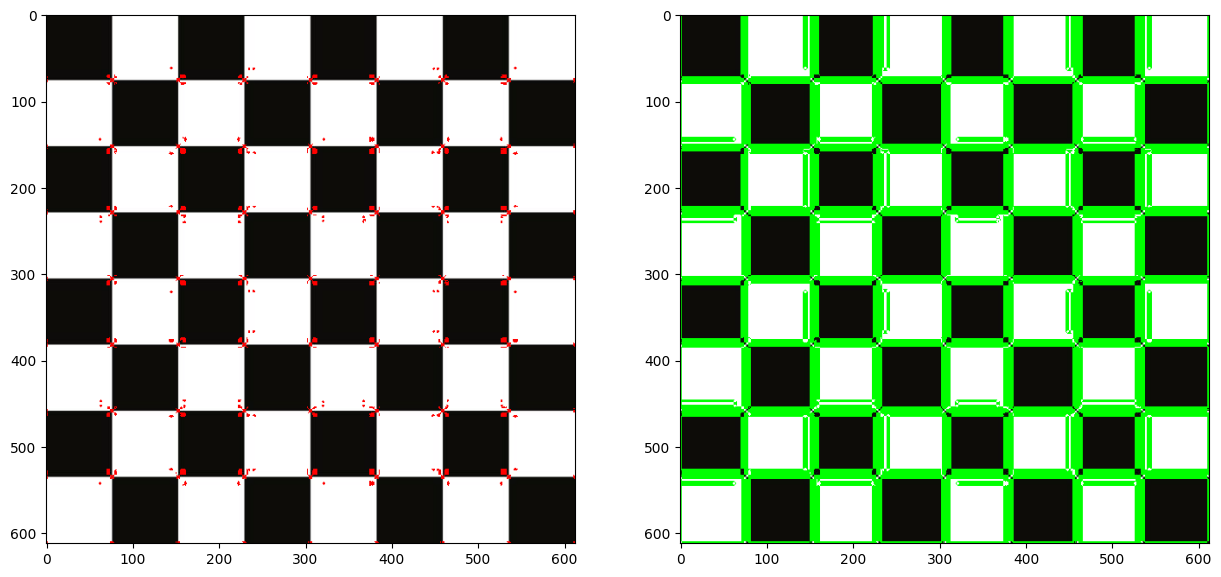

In [10]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

# Challenge <a class="anchor" name="challenge" />

a) En el Collab de Harris Detector, se sugiere que se hagan pruebas con imágenes propias que el equipo decida usar. La idea  es escoger un objeto y tomar fotos con diferentes tipos de iluminación (bajo el sol, en un lugar oscuro) y bajo diferentes ángulos para analizar el comportamiento del detector de Harris bajo diferentes settings

In [11]:
def adjust_brightness(img, beta = 0):
  return cv2.convertScaleAbs(img, alpha=1.0, beta=beta)

def rotate(img, angle = 45, scale_factor = 1.0):
  # Define el centro de rotacion
  (h, w) = img.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, scale_factor)
  return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def read_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img.astype(np.float32)

def convert_to_grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img
  # return np.float32

def get_harris_mask(img_gray, blockSize = 3, ksize = 3, k = 0.05, threshold = 0.01):
  gray_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
  dst = cv2.cornerHarris(gray_blur, blockSize, ksize, k)
  # para suavizar los picos
  dst = cv2.dilate(dst, None)
  # threshold para dibujar los corners
  # mayor si muchas esquinas o menor si detecta pocas.
  harris_mask = dst > threshold * dst.max()
  return harris_mask

def apply_harris(img, img_gray, blockSize = 3, ksize = 3, k = 0.05, threshold = 0.01):
  harris_mask = get_harris_mask(img_gray, blockSize, ksize, k, threshold)
  result = img.copy()
  result[harris_mask]=[255, 0, 0]
  return result

def apply_edges(img, img_gray, blockSize = 3, ksize = 3, k = 0.05, threshold = 0.01):
  gray_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
  dst = cv2.cornerHarris(img_gray, blockSize, ksize, k)
  norm = cv2.normalize(dst, None, 0, 255, cv2.NORM_MINMAX)
  img_uint8 = np.uint8(norm)
  # usamos canny para ver los bordes de la respuesta de harris
  edges_from_harris = cv2.Canny(img_uint8, 50, 150)
  # Se aplica en la version a escala de grises para observarlo mejor
  result = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
  result[edges_from_harris != 0] = [0, 255, 0]
  return result

def draw_experiment(img, figsize=(10,6)):
  # Obtenemos la imagen en escala de grises para Harris
  img_gray = convert_to_grayscale(img)
  # Obtenemos los corners
  img_corners = apply_harris(img, img_gray, threshold=0.008)
  # Obtenemos los edges usando harris
  img_edges = apply_edges(img, img_gray, threshold=0.008)

  plt.figure(figsize=figsize)
  plt.subplot(1, 3, 1), plt.title('Original'); plt.imshow(img.astype(np.uint8)); plt.axis('off');
  plt.subplot(1, 3, 2), plt.title('Harris Corners'); plt.imshow(img_corners.astype(np.uint8)); plt.axis('off');
  plt.subplot(1, 3, 3), plt.title('Edges from Harris'); plt.imshow(img_edges.astype(np.uint8)); plt.axis('off');
  plt.tight_layout()

# Obtenemos el siguiente par de imagenes por medio de un generador
def img_generator(imgs):
    idx = 0
    while idx < len(imgs):
        yield imgs[idx]
        idx += 1

def scale_image(img, scale_factor = 1):
    height, width = img.shape[:2]
    new_size = (int(width * scale_factor), int(height * scale_factor))
    scaled = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
    return scaled


In [12]:
imgs = [read_image(f"data/{i+1:03}.jpg") for i in range(19)]
img_gen = img_generator(imgs)

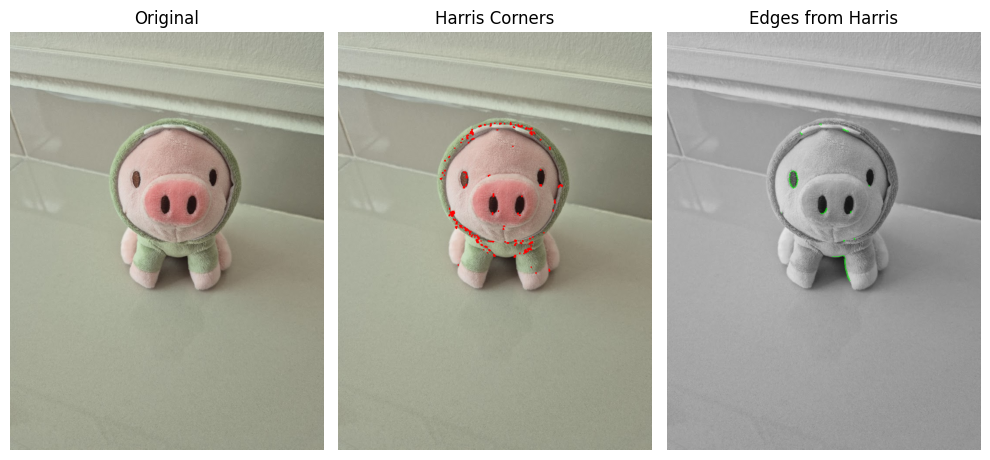

In [13]:
draw_experiment(next(img_gen))

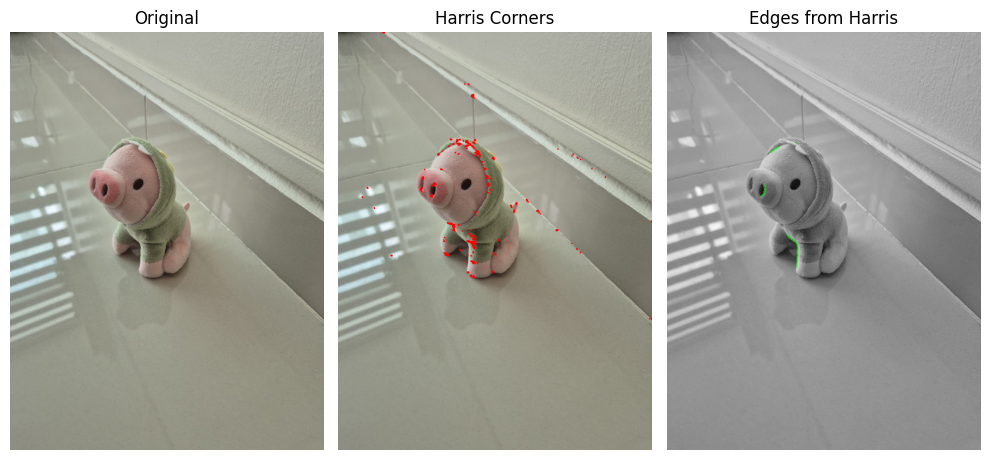

In [14]:
draw_experiment(next(img_gen))

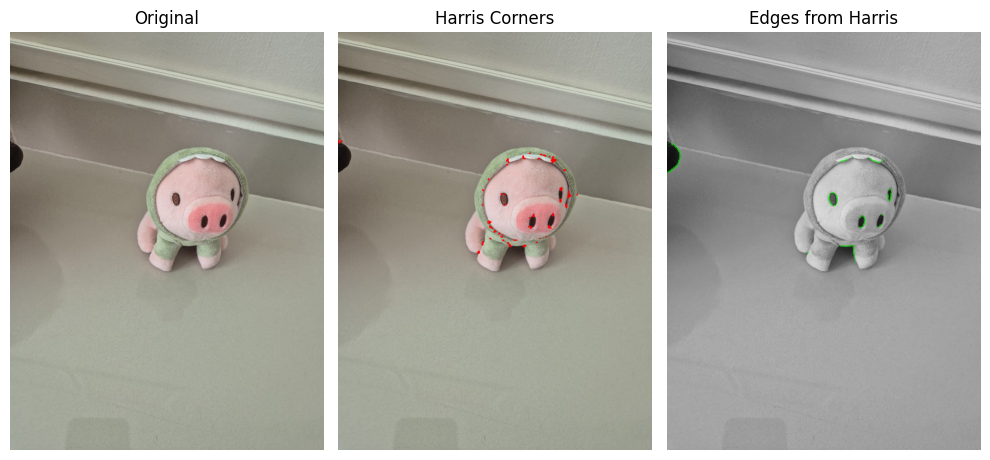

In [15]:
draw_experiment(next(img_gen))

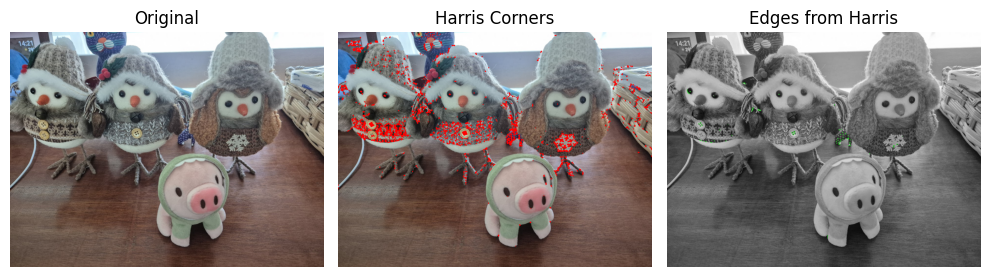

In [16]:
draw_experiment(next(img_gen))

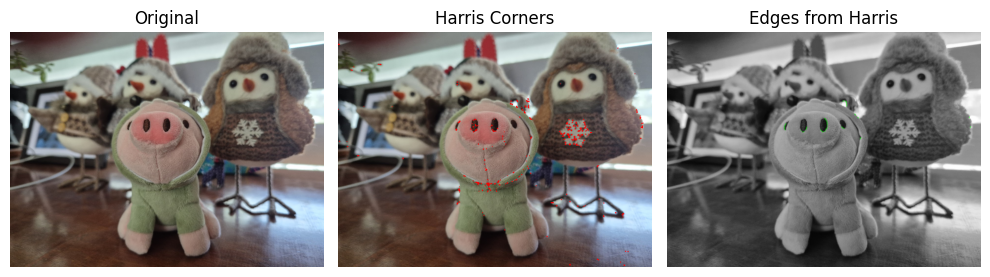

In [17]:
draw_experiment(next(img_gen))

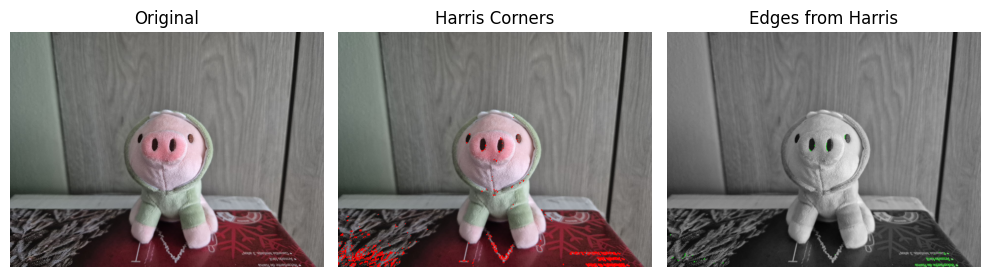

In [18]:
draw_experiment(next(img_gen))

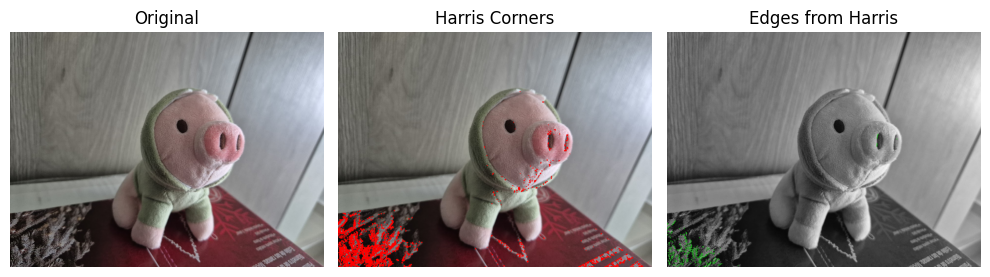

In [19]:
draw_experiment(next(img_gen))

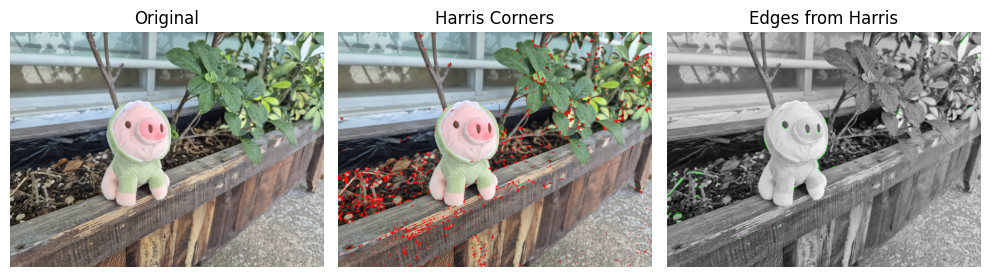

In [20]:
draw_experiment(next(img_gen))

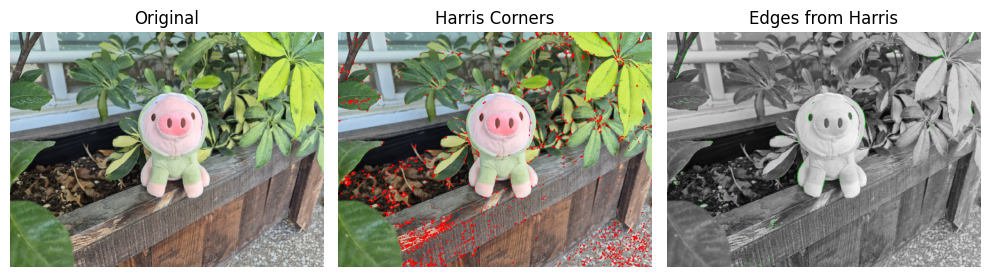

In [21]:
draw_experiment(next(img_gen))

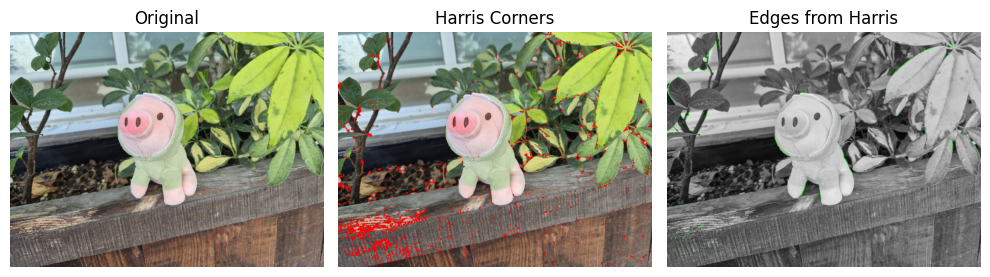

In [22]:
draw_experiment(next(img_gen))

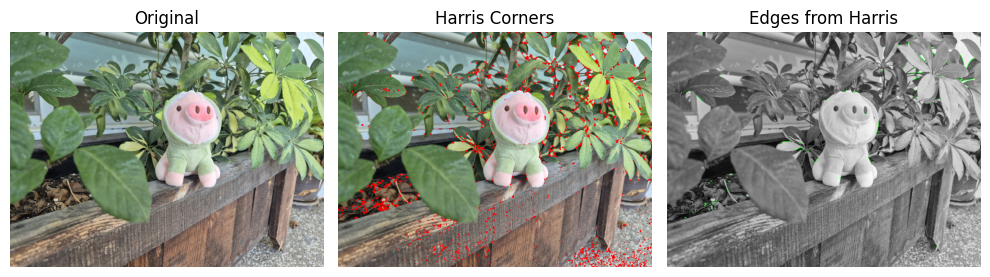

In [23]:
draw_experiment(next(img_gen))

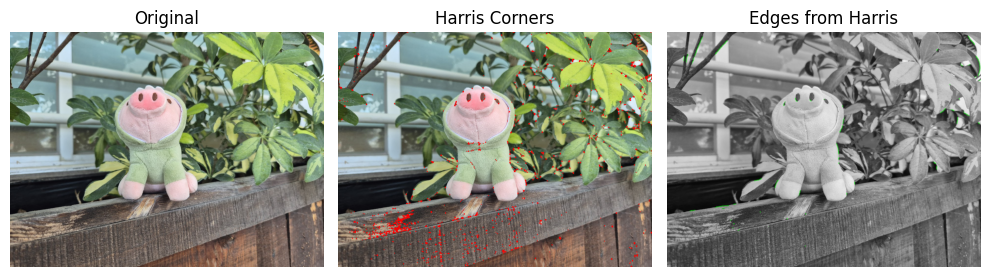

In [24]:
draw_experiment(next(img_gen))

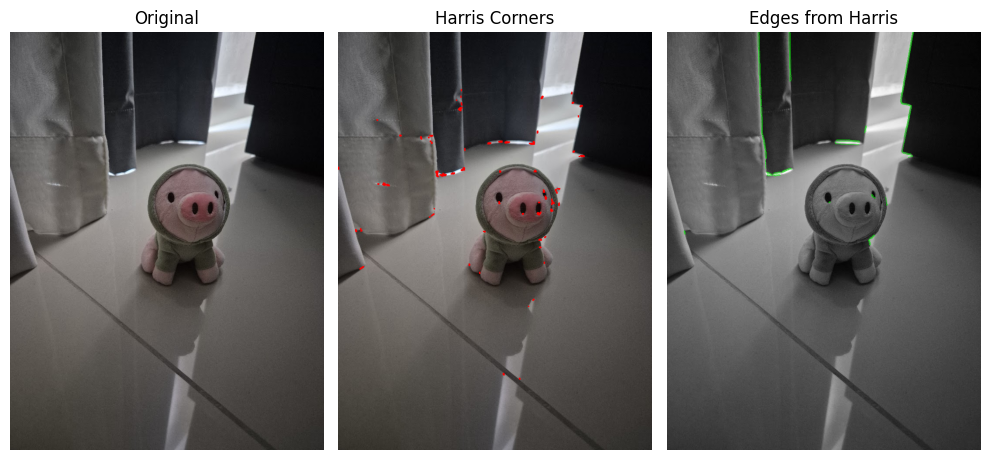

In [25]:
draw_experiment(next(img_gen))

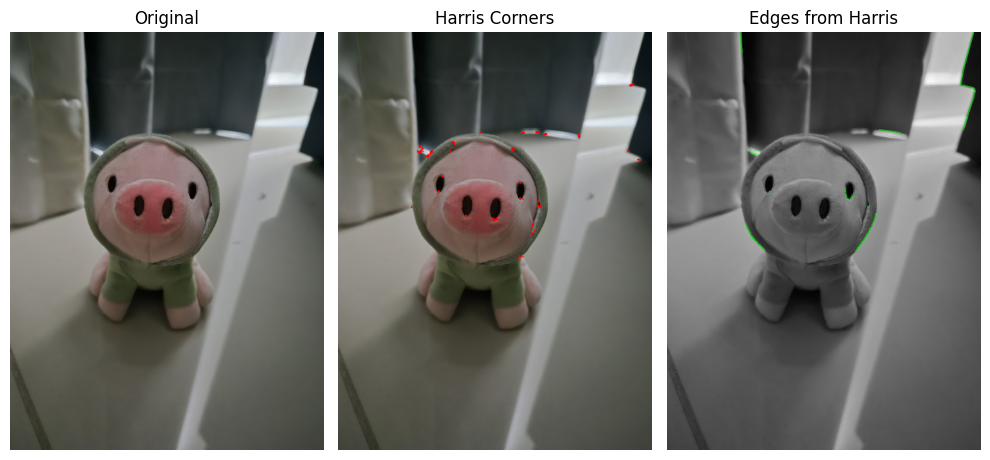

In [26]:
draw_experiment(next(img_gen))

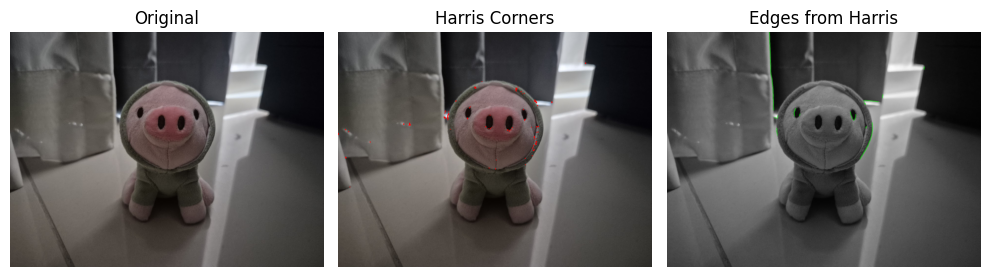

In [27]:
draw_experiment(next(img_gen))

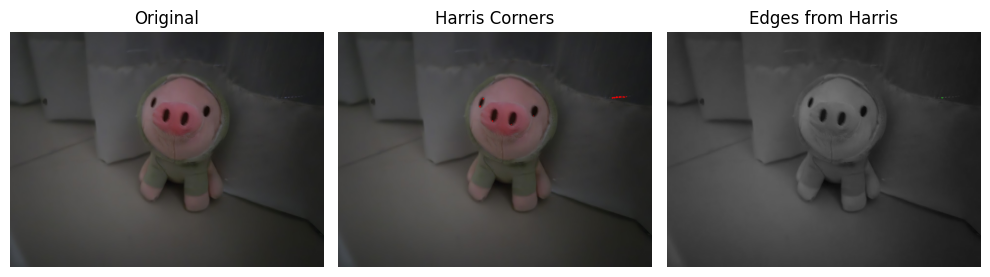

In [28]:
draw_experiment(next(img_gen))

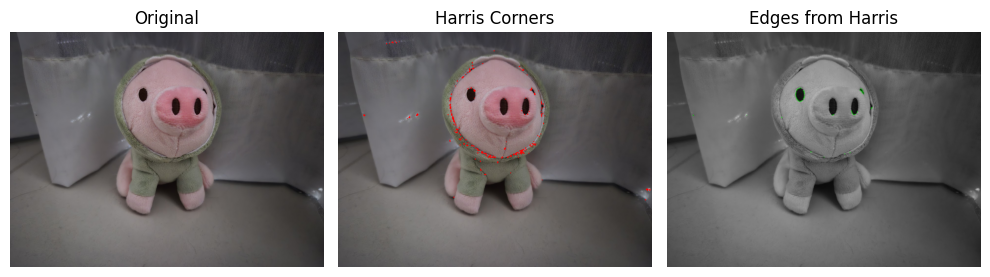

In [29]:
draw_experiment(next(img_gen))

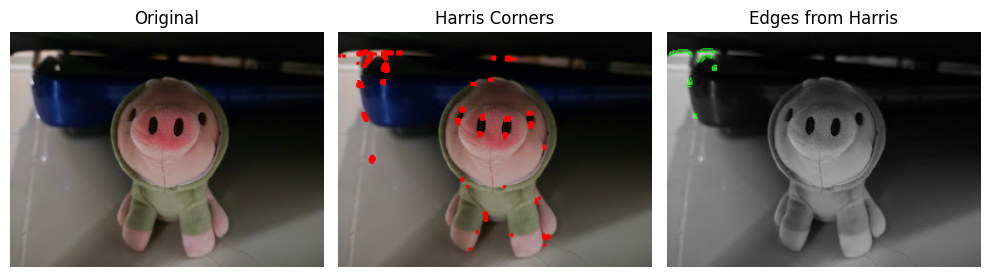

In [30]:
draw_experiment(next(img_gen))

In [31]:
# Comparación de Harris con la misma imagen rotada y escalada
base_image_01 = imgs[0]
scale_01 = scale_image(base_image_01, 0.5)
rot_01 = rotate(base_image_01, angle=30)

Original


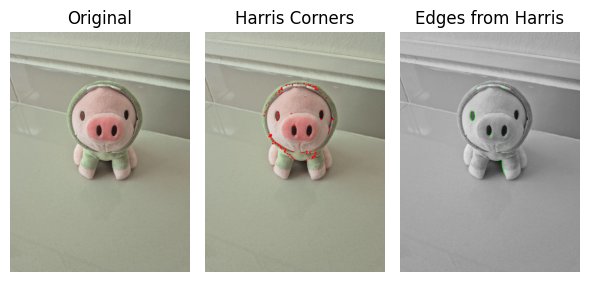

In [32]:
print("Original")
draw_experiment(base_image_01, figsize=(6,4))

Escala 0.5


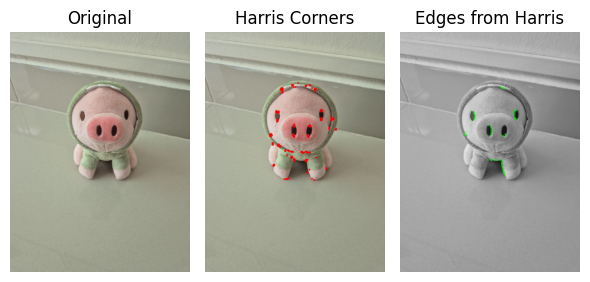

In [33]:
print("Escala 0.5")
draw_experiment(scale_01, figsize=(6,4))

Rotacion 45


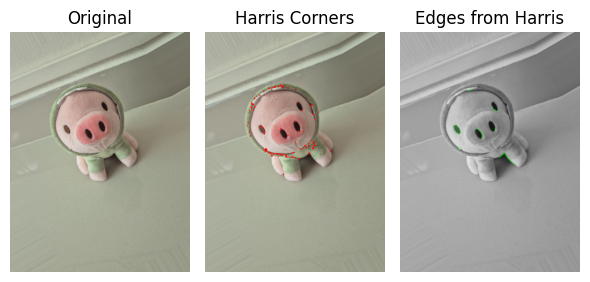

In [34]:
print("Rotacion 45")
draw_experiment(rot_01, figsize=(6,4))

In [35]:
# Comparación de Harris con la misma imagen rotada y escalada
base_image_02 = imgs[1]
scale_02 = scale_image(base_image_02, 5)
rot_02 = rotate(base_image_02)

Original


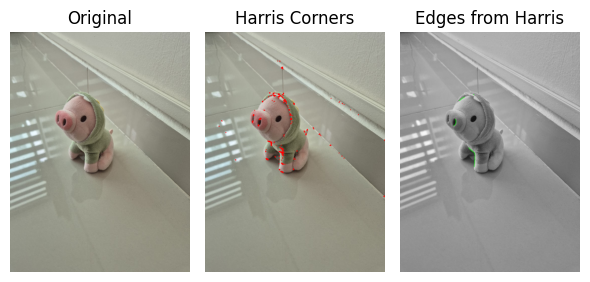

In [36]:
print("Original")
draw_experiment(base_image_02, figsize=(6,4))

Rotación 45


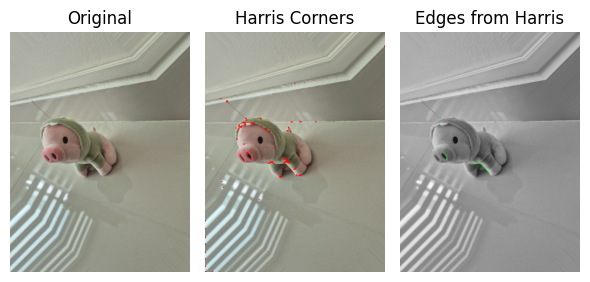

In [37]:
print("Rotación 45")
draw_experiment(rot_02, figsize=(6,4))

Escala 5x


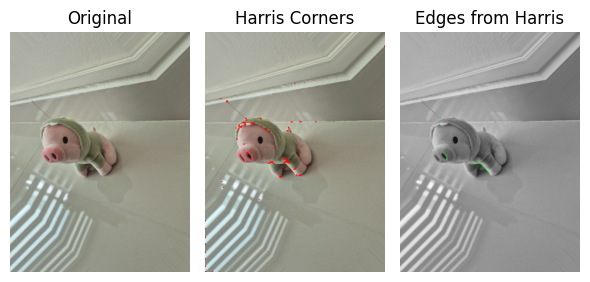

In [38]:
print("Escala 5x")
draw_experiment(rot_02, figsize=(6,4))

## Introducción

La extracción de características, en visión computacional se refiere a puntos de regiónes de interés en una imagen, estos puntos son útiles para reconocer o comparar una imagen (por ejemplo coincidencias entre fotos).

El proceso tiene dos pasos:
- *Detección de puntos clave* (keypoints detection), que es identificar ubicaciones relevantes (esquinas, bordes, regiones con alto contraste, etc.)
- *Descriptores* (feature description) que es representar cada punto como un vector numérico (su “huella digital”) para poder compararlo entre imágenes.

### El Detector de Harris

Este detector tiene como objetivo detectar esquinas (corners) enuna imagen, ya que son puntos donde la intensidad cambia en dos direcciones.

Su idea es:
- Si te mueves un poco en cualquier dirección de una región, la intensidad no varia mucho.
- Si te mueves sobre un borde, la dirección cambia.
- Si te mueves en una esquina, cambia en todas las direcciones.

## Discusión <a class="anchor" name="discusion" />

Lo que se pudo notar en general al aplicarlo en el set de imagenes de prueba fue:
**Pros**
- Es simple y rápido
- Puede servir para un seguimiento simple.
- Sigue teniendo una detección fiable aun con rotación.

**Contras:**
- Cuando se aplica escala, comienza a tener variaciones en los bordes
- No produce descriptores, solo las coordenadas.

Podemos observar que con nuestro objeto de prueba (peluche de puerco disfrazado de cocodrilo), los keypoints son sobre la cara, ojos y nariz, algunas con mayor o menor medida.

Por ejemplo con ciertos angulos y con fondos llenos de esquinas, estos keypoints fueron menores, por ejemplo con el fondo de plantas o con las 3 figuras de aves.

También le costo trabajo cuando faltaba iluminación y la imagen era muy borrosa.

En la parte de la escala, pudimos observar como se intensifican las esquinas si hacemos la imagen más pequeña

## Conclusiones

En esta actividad vimos el uso del detector de Harris, y pudimos concluir que  Harris responde a los valores de la matriz de gradientes, que son independientes de la orientación. Por eso, las esquinas suelen detectarse correctamente aunque la imagen gire (y cuando mantenga la misma perspectiva).

Si el cambio de luz es uniforme (toda la imagen más clara u oscura), las derivadas cambian proporcionalmente y el resultado sigue siendo razonable. Pero si hay sombras o variaciones locales fuertes, puede perder esquinas o generar falsas detecciones.

Harris usa un tamaño fijo de ventana (blockSize), por lo que una esquina pequeña puede desaparecer si la imagen se reduce, o detecta más esquinas de las normales cuando la imagen es muy grande.


## Referencias:

[1] González, R. C., & Woods, R. E. (2018). Digital Image Processing (4th ed.). Pearson.
